# Architecture of a CNN

* Input image(s): target images youd like to discover patterns in. Whatever you can take a phot(or video) of.
* Input layer: Takes in target images and preprocesses them for further layers. `input_shape = [batch_size, image_height, image_width, color_channels]`
* Convolution layer: Extracts/learns the most important features from target images. Multiple value options, can create with `tf.keras.layers.ConvXD (X can be multiple values)`
* Hidden activation: Adds non-linearity to learned features. Usually ReLU.
* Pooling layer: Reduces the dimensionality of learned image features. Average `tf.keras.layers.AvgPool2D` or Max `tf.keras.layers.MaxPool2D`
* Fully connected layer: Further refines learned features from convolution layers. `tf.keras.layers.Dense()`
* Output layer: Takes learned features and outputs them in shape of target labels. `output_shape = [num of classes] (eg, 3 for steak, pizza or sushi)`
* Output activation: Adds non-linearities to output layer. `tf.keras.activations.sigmoid or tf.keras.activations.softmax`

### Get the data

Images were working with are from Food101 dataset (101 classes of food). We've modified the dataset to only use 2 sets of classes which was modified in the file: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb


Start with a smaller dataset so we can expirement quickly to find out what works before scaling up.

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip # will download zip file and download into colab

# unzip for colab directory
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()



--2023-12-11 00:35:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M   199MB/s    in 0.5s    

2023-12-11 00:35:12 (199 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



## Inspect the data(become one with it)

A very crucial step at the beginning of any machine leanrning project is becoming one with the data.

In [ ]:
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train/steak

1000205.jpg  1598345.jpg  2062248.jpg  2548974.jpg  3030578.jpg  3571963.jpg  510757.jpg
100135.jpg   1598885.jpg  2081995.jpg  2549316.jpg  3047807.jpg  3576078.jpg  513129.jpg
101312.jpg   1600179.jpg  2087958.jpg  2561199.jpg  3059843.jpg  3577618.jpg  513842.jpg
1021458.jpg  1600794.jpg  2088030.jpg  2563233.jpg  3074367.jpg  3577732.jpg  523535.jpg
1032846.jpg  160552.jpg   2088195.jpg  256592.jpg   3082120.jpg  3578934.jpg  525041.jpg
10380.jpg    1606596.jpg  2090493.jpg  2568848.jpg  3094354.jpg  358042.jpg   534560.jpg
1049459.jpg  1615395.jpg  2090504.jpg  2573392.jpg  3095301.jpg  358045.jpg   534633.jpg
1053665.jpg  1618011.jpg  2125877.jpg  2592401.jpg  3099645.jpg  3591821.jpg  536535.jpg
1068516.jpg  1619357.jpg  2129685.jpg  2599817.jpg  3100476.jpg  359330.jpg   541410.jpg
1068975.jpg  1621763.jpg  2133717.jpg  2603058.jpg  3110387.jpg  3601483.jpg  543691.jpg
1081258.jpg  1623325.jpg  2136662.jpg  2606444.jpg  3113772.jpg  3606642.jpg  560503.jpg
1090122.jpg  1624450.

In [ ]:
import os

# walk thru pizza_steak dir and list num of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

There are 2 directories and 0 images in 'pizza_steak'. 
There are 2 directories and 0 images in 'pizza_steak/test'. 
There are 0 directories and 250 images in 'pizza_steak/test/pizza'. 
There are 0 directories and 250 images in 'pizza_steak/test/steak'. 
There are 2 directories and 0 images in 'pizza_steak/train'. 
There are 0 directories and 750 images in 'pizza_steak/train/pizza'. 
There are 0 directories and 750 images in 'pizza_steak/train/steak'. 


In [ ]:
# another way to see how many images in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize our images first lets get the classnames programatically

In [ ]:
# get the classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # created list of classnames from list of sub directories
# if you get DS_Store, just remove it from array class_names[1:]
print(class_names)

['pizza' 'steak']


In [ ]:
# lets visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # setup target directory (well view images from here)
  target_folder = target_dir + target_class

  # get random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # read the image and plot it using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

['2091857.jpg']
Image shape: (512, 512, 3)


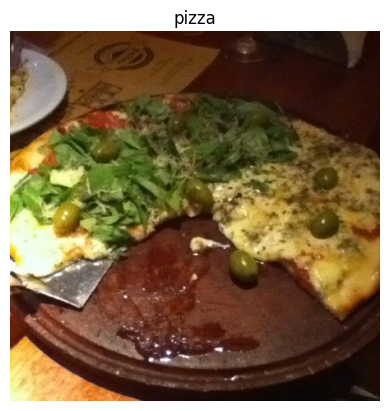

In [ ]:
# view a random image from training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class='pizza')

In [ ]:
import tensorflow as tf
tf.constant(img) # the image transformed into tensors (rgb color channels)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 52,  26,  25],
        [ 50,  24,  23],
        [ 55,  30,  26],
        ...,
        [ 29,  12,   5],
        [ 29,  11,   7],
        [ 30,  12,   8]],

       [[ 50,  24,  23],
        [ 48,  22,  21],
        [ 52,  27,  23],
        ...,
        [ 29,  12,   5],
        [ 29,  11,   7],
        [ 29,  11,   7]],

       [[ 52,  27,  23],
        [ 48,  23,  19],
        [ 47,  22,  18],
        ...,
        [ 30,  13,   6],
        [ 29,  11,   7],
        [ 29,  11,   7]],

       ...,

       [[244, 255, 206],
        [244, 255, 206],
        [245, 255, 205],
        ...,
        [ 41,  32,  27],
        [ 41,  32,  27],
        [ 39,  30,  25]],

       [[245, 254, 207],
        [244, 253, 206],
        [244, 254, 204],
        ...,
        [ 33,  24,  19],
        [ 33,  24,  19],
        [ 32,  23,  18]],

       [[242, 251, 204],
        [242, 251, 204],
        [241, 251, 201],
        ...,
        [ 32,  23,  1

In [ ]:
# view the image shape
img.shape # returns width, height, color channels

(512, 512, 3)

In [ ]:
# get all the pixels values between 0 & 1
img / 255.

array([[[0.20392157, 0.10196078, 0.09803922],
        [0.19607843, 0.09411765, 0.09019608],
        [0.21568627, 0.11764706, 0.10196078],
        ...,
        [0.11372549, 0.04705882, 0.01960784],
        [0.11372549, 0.04313725, 0.02745098],
        [0.11764706, 0.04705882, 0.03137255]],

       [[0.19607843, 0.09411765, 0.09019608],
        [0.18823529, 0.08627451, 0.08235294],
        [0.20392157, 0.10588235, 0.09019608],
        ...,
        [0.11372549, 0.04705882, 0.01960784],
        [0.11372549, 0.04313725, 0.02745098],
        [0.11372549, 0.04313725, 0.02745098]],

       [[0.20392157, 0.10588235, 0.09019608],
        [0.18823529, 0.09019608, 0.0745098 ],
        [0.18431373, 0.08627451, 0.07058824],
        ...,
        [0.11764706, 0.05098039, 0.02352941],
        [0.11372549, 0.04313725, 0.02745098],
        [0.11372549, 0.04313725, 0.02745098]],

       ...,

       [[0.95686275, 1.        , 0.80784314],
        [0.95686275, 1.        , 0.80784314],
        [0.96078431, 1

Many machine learning models prefer the values they work with to be between 0 and 1.

## An end-to-end example

Lets build a convolutional neural network to find patterns in our images.

* load images
* preprocess images
* build a CNN to find patterns in images
* compile CNN
* fit the CNN to training data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

# preprocess the data(get all pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# setup paths to our data directory
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224), # reshape all images to 224, 224. Chose those numbers just cause their common
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
# build a CNN model (same as tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 7s 117ms/step - loss: 0.5854 - accuracy: 0.6847 - val_loss: 0.4071 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 7s 139ms/step - loss: 0.4389 - accuracy: 0.7927 - val_loss: 0.3908 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 5s 114ms/step - loss: 0.4117 - accuracy: 0.8167 - val_loss: 0.3777 - val_accuracy: 0.8460
Epoch 4/5
47/47 [==============================] - 6s 129ms/step - loss: 0.3725 - accuracy: 0.8400 - val_loss: 0.4130 - val_accuracy: 0.8180
Epoch 5/5
47/47 [==============================] - 6s 126ms/step - loss: 0.3176 - accuracy: 0.8713 - val_loss: 0.3399 - val_accuracy: 0.8500


In [ ]:
train_data

NameError: ignored

In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

If the above cell is taking longer than 10 seconds per epoch, use a gpu

## using the same model as before for circles on the image dataset (non-CNN)

Use the model from circles onto the image data

In [ ]:
tf.random.set_seed(42)

# create model to replicate tensorflow playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 162ms/step - loss: 0.6966 - accuracy: 0.5140 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 7s 148ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 129ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 105ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 110ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [ ]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 4)                 602116    
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Try to improve model_2 without using convolutional neural network. Despite having 20x more total params, performs horribly

In [ ]:
tf.random.set_seed(42)

# create model to replicate tensorflow playground model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 10s 127ms/step - loss: 3.1722 - accuracy: 0.6367 - val_loss: 1.1527 - val_accuracy: 0.6860
Epoch 2/5
47/47 [==============================] - 7s 144ms/step - loss: 0.9591 - accuracy: 0.6907 - val_loss: 0.5108 - val_accuracy: 0.7820
Epoch 3/5
47/47 [==============================] - 7s 152ms/step - loss: 0.6439 - accuracy: 0.7327 - val_loss: 0.8653 - val_accuracy: 0.6740
Epoch 4/5
47/47 [==============================] - 10s 202ms/step - loss: 0.6223 - accuracy: 0.7460 - val_loss: 0.4840 - val_accuracy: 0.7880
Epoch 5/5
47/47 [==============================] - 6s 134ms/step - loss: 0.4798 - accuracy: 0.7867 - val_loss: 0.4399 - val_accuracy: 0.7860


In [ ]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_6 (Dense)             (None, 100)               15052900  
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


15 Million trainable parameters is too much. Which is over 500 times the params of our convolutional neural network (model_1).

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.



Think of trainiable params as patterns a model can learn from data. Intuitively you might think more is better. And in lots of cases, it is. But in this case, the difference here is the 2 different styles of model we're using. Where a series of dense layers has a number of different learnable params connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image.** So even though these are less learnable parameters in our convolutional neural network, these are often more helpful in deciphering between different features in an image

## Binary Classification: Break it down

1. become one with data
2. preprocess the data(prepare for model, scaling normalization)
3. create a model (start with a baseline)
4. fit the model
5. evaluate the model
6. adjust different parameters and improve the model (try to beat our baseline)
7. repeat until satisfied


['146833.jpg']
Image shape: (341, 512, 3)
['3512070.jpg']
Image shape: (512, 512, 3)


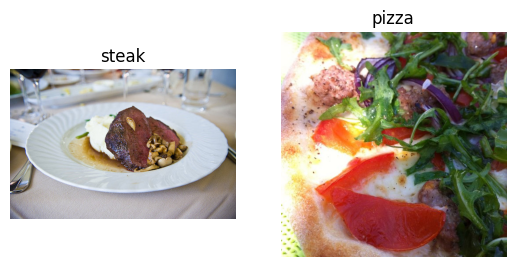

In [ ]:
# 1. become one with data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

## 2. Preprocess the data and prepare for it

In [ ]:
# define directory dataset paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into batches.

A batch is a small subset of data. Rather than look at all ~10,000 images at one time, a model might only look at 32 at a time.

It does this for a couple reasons:
1. 10,000 image (or more) might not fit into memory of your processor(GPU)
2. Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?
https://twitter.com/ylecun/status/989610208497360896?lang=en


In [ ]:
!nvidia-smi

Mon Dec 11 00:37:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |   2363MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=32)
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# get a sample of a train data batch
images, labels = train_data.next() # get the next batch of images/labels in train_data
len(images), len(labels)

(32, 32)

In [ ]:
# how many batches are there
len(train_data)

47

In [ ]:
# get the frst 2 images
images[:2], images[0].shape
# [0.47058827, 0.40784317, 0.34509805] = r, g, b

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [ ]:
images[7].shape

(224, 224, 3)

In [ ]:
# view the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a CNN model(start with baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning expirement and then as you keep experimenting, you try yo beat the baseline


In deep learning there is an infinite amount of architecture you coud create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (eg, look at which current model is performing best in the field for your problem)

In [ ]:
# make the creating of model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
model_4 = Sequential([
    Conv2D(filters=10, # num of sliding windows going across an input
           kernel_size=3, # same as 3x3. The size of the sliding window going across an input
           strides=1, # the size of the step the sliding window takes across an input b
           padding="valid", # if same, output shape is same as input_shape, if valid, output shape gets compressed
           activation="relu",
           input_shape=(224, 224, 3)), # input layer (specify input shape)
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid") # output layer (working with binary classification so only output 1 neuron)
])

### Breaking down Conv2D Layer

* Filters - decides how many filters should pass over an input tensor(eg, sliding windows over an image). Values = 10, 32, 64, 128(higher lead to more complex models)
* Kernal size - determines the shape of the filters over the output. values = 3, 5, 7(lower values learn smaller features, larger learns larger features)
* Padding - Pads the target tensor with zeroes (same) to preserve input shape. Or leaves in the target tensor as is (valid), lowering output shape. Values = same or valid.
* Strides - num of steps a filter takes across an image at a time (strides=1, a filter moves across an image 1 pixel at a time). Values = 1(default), 2

https://poloclub.github.io/cnn-explainer/

In [ ]:
# compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_14 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_5 (Flatten)         (None, 475240)            0         
                                                                 
 dense_10 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fit the model

In [ ]:
# check the lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [ ]:
# fit the model
history_4 = model_4.fit(train_data, # this is a combination of steak and pizza
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 15s 288ms/step - loss: 0.9980 - accuracy: 0.6147 - val_loss: 0.5685 - val_accuracy: 0.7020
Epoch 2/5
47/47 [==============================] - 8s 160ms/step - loss: 0.5016 - accuracy: 0.7567 - val_loss: 0.4442 - val_accuracy: 0.8040
Epoch 3/5
47/47 [==============================] - 9s 191ms/step - loss: 0.3968 - accuracy: 0.8340 - val_loss: 0.4336 - val_accuracy: 0.7720
Epoch 4/5
47/47 [==============================] - 8s 161ms/step - loss: 0.2716 - accuracy: 0.8953 - val_loss: 0.3833 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 7s 156ms/step - loss: 0.1135 - accuracy: 0.9693 - val_loss: 0.4326 - val_accuracy: 0.8240


In [ ]:
model_1.evaluate(test_data)

16/16 [==============================] - 1s 85ms/step - loss: 0.3399 - accuracy: 0.8500


[0.3399216830730438, 0.8500000238418579]

In [ ]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_11 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

In [ ]:
model_4.evaluate(test_data)

16/16 [==============================] - 1s 86ms/step - loss: 0.4326 - accuracy: 0.8240


[0.432619571685791, 0.8240000009536743]

### 5. Evaluating our model

It looks like our model is learning something, lets evaluate it

<Axes: >

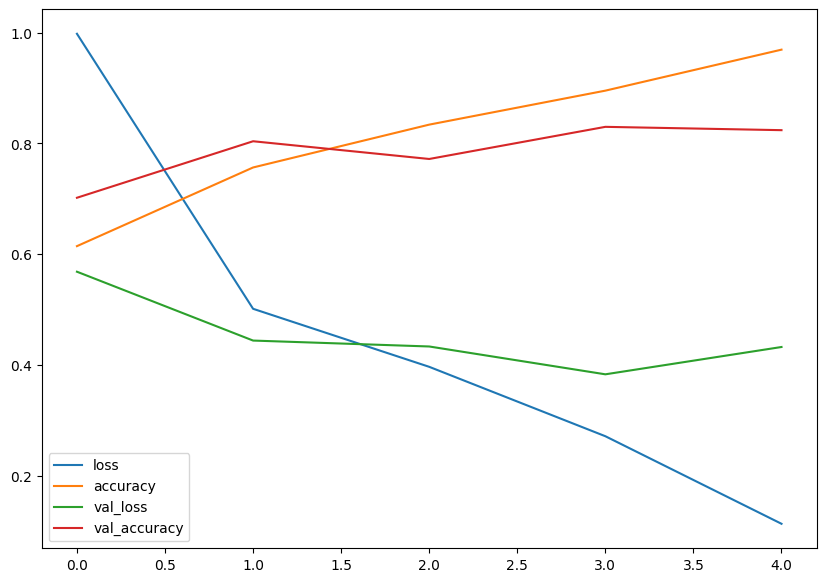

In [ ]:
# plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))

In [ ]:
# plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

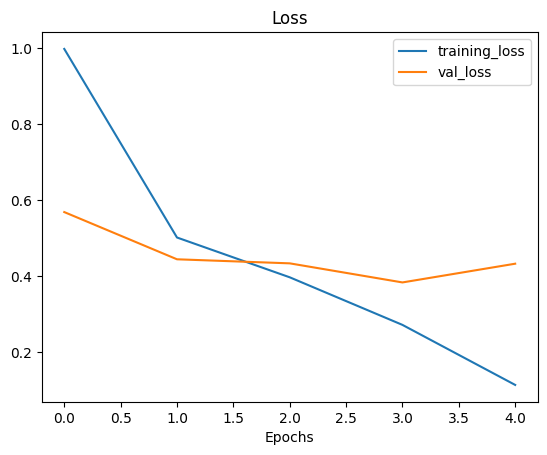

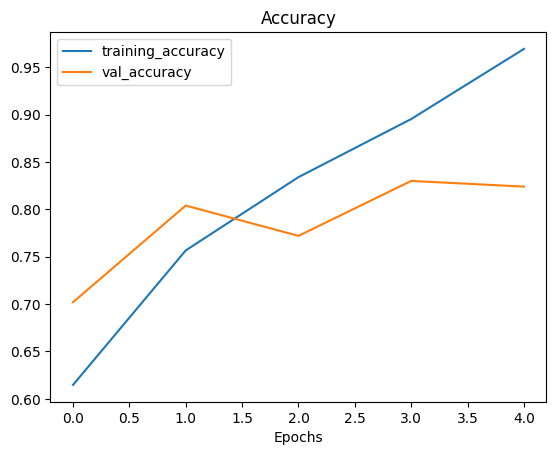

In [ ]:
# check out the loss and accuracy of model_4
plot_loss_curves(history_4)

Note: when a models validation loss starts to increase, its likely that the model is overfitting the train dataset. This means, its learning the patterns in the training dataset too well and thus the models ability to generalize the unseen data will be diminished.  

### 6. adjust the model parameters

Fitting a machine learning model comes in 3 steps:
0. Create a baseline
1. Beat a baseline by overfitting a larger model
2. reduce overfitting

Ways to induce overfitting:
* increase num of conv layers
* increase num of conv filters
* add another dense layer to the output of our flattened layer.

Reduce overfitting:
* data augmentation
* add regularization layers (such as MaxPool2d)
* Add more data...

In [ ]:
# create the model (this will be our new baseline)
model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid") # output layer (working with binary classification so only output 1 neuron)
])

In [ ]:
# compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 128ms/step - loss: 0.6083 - accuracy: 0.6580 - val_loss: 0.4649 - val_accuracy: 0.7940
Epoch 2/5
47/47 [==============================] - 8s 168ms/step - loss: 0.4378 - accuracy: 0.8067 - val_loss: 0.3861 - val_accuracy: 0.8200
Epoch 3/5
47/47 [==============================] - 5s 107ms/step - loss: 0.4058 - accuracy: 0.8227 - val_loss: 0.3221 - val_accuracy: 0.8580
Epoch 4/5
47/47 [==============================] - 5s 112ms/step - loss: 0.3743 - accuracy: 0.8393 - val_loss: 0.4393 - val_accuracy: 0.7780
Epoch 5/5
47/47 [==============================] - 6s 128ms/step - loss: 0.3608 - accuracy: 0.8480 - val_loss: 0.2895 - val_accuracy: 0.8820


In [ ]:
model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 10)       

In [ ]:
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_14 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_5 (Flatten)         (None, 475240)            0         
                                                                 
 dense_10 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


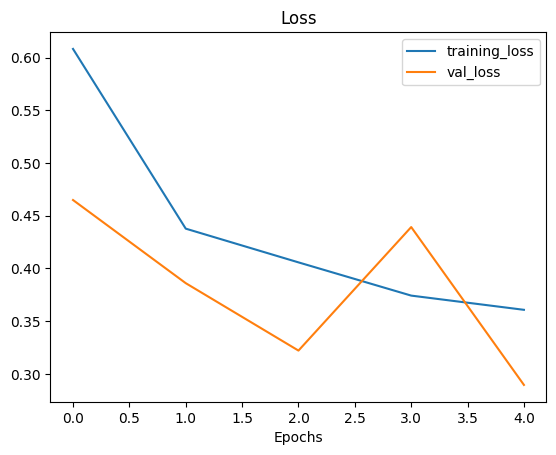

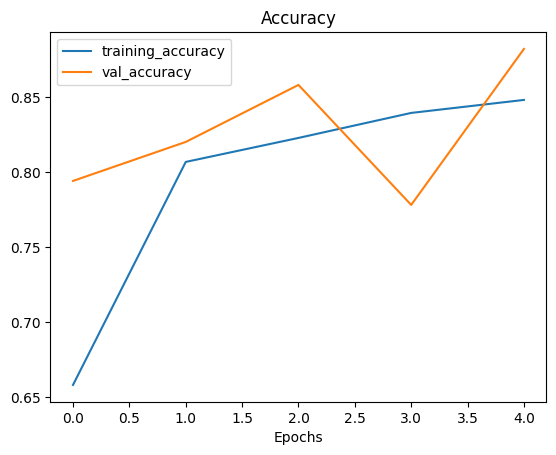

In [ ]:
# plot loss curves
plot_loss_curves(history_5)

### Data augmentation

In [ ]:
# create ImageDataGenerator training instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255,
                                             rotation_range=0.2, # how much do u want to rotate an image
                                             shear_range=0.2, #
                                             zoom_range=0.2,
                                             width_shift_range=0.2, # move image around on the y axis
                                             height_shift_range=0.3, # move image around on the y axis
                                             horizontal_flip=True)

# create image data generator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)

### What is data Augmentation?

Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it, or something similar.

In [ ]:
# visualize data augmentation
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


Data augmentation is usually only performed on training data. Using `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are modified as they're loaded into the model.

In [ ]:
# Get sample data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

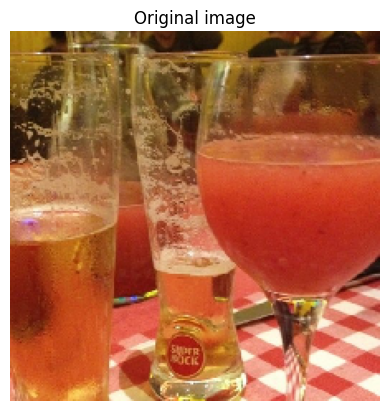

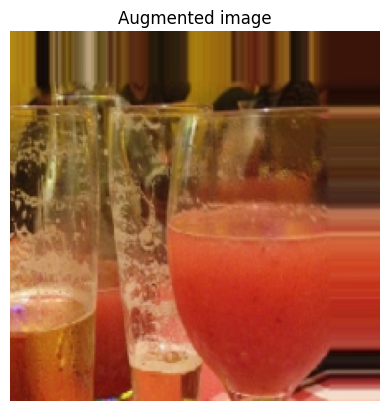

In [ ]:
# show original image and augmented image
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Now we've seen what augmented training data looks like, lets build a model and see how it learns on the augmneted data.

In [ ]:
# create a model
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 33s 680ms/step - loss: 0.9031 - accuracy: 0.4953 - val_loss: 0.6927 - val_accuracy: 0.5040
Epoch 2/5
47/47 [==============================] - 22s 471ms/step - loss: 0.6935 - accuracy: 0.4993 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 21s 438ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 22s 470ms/step - loss: 0.6920 - accuracy: 0.5293 - val_loss: 0.6882 - val_accuracy: 0.5420
Epoch 5/5
47/47 [==============================] - 22s 479ms/step - loss: 0.7529 - accuracy: 0.5533 - val_loss: 0.6906 - val_accuracy: 0.5000


When our model is fit on train_data_augmented it doesnt alter the train data in the local files. Training data stays the same.

The reason why this takes longer is b/c the train_data_augmented augments data on the fly, as its loaded in. Which takes up some preprocess power. Thats why it takes longer.

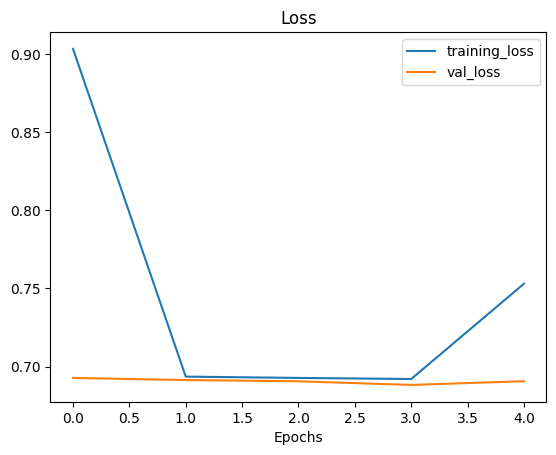

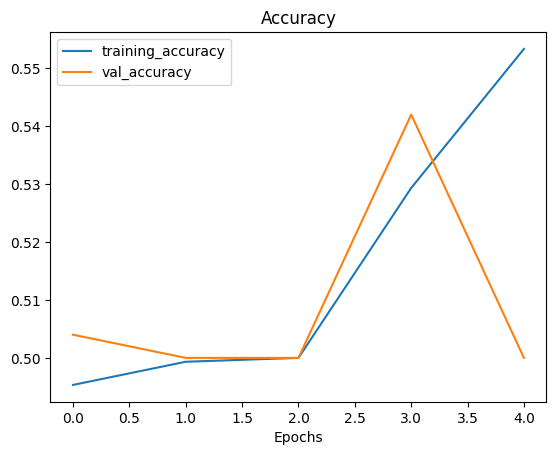

In [ ]:
# check our models training curves
plot_loss_curves(history_6)

If the loss curve goes up near the end it might be hinting that our model is starting to be overfitting.


---



Lets shuffle our augmented training data and train another model the same as before and see what happens.



In [ ]:
# import data and augment it and shuffle it from training directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

Found 1500 images belonging to 2 classes.


In [ ]:
# create the model same as model_5 and 6.
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # fitting on augmented and shuffled data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 21s 426ms/step - loss: 0.6522 - accuracy: 0.6293 - val_loss: 0.5143 - val_accuracy: 0.7660
Epoch 2/5
47/47 [==============================] - 22s 457ms/step - loss: 0.5628 - accuracy: 0.7187 - val_loss: 0.5123 - val_accuracy: 0.7220
Epoch 3/5
47/47 [==============================] - 22s 460ms/step - loss: 0.5139 - accuracy: 0.7593 - val_loss: 0.3708 - val_accuracy: 0.8340
Epoch 4/5
47/47 [==============================] - 22s 468ms/step - loss: 0.4937 - accuracy: 0.7773 - val_loss: 0.3711 - val_accuracy: 0.8320
Epoch 5/5
47/47 [==============================] - 20s 428ms/step - loss: 0.4786 - accuracy: 0.7680 - val_loss: 0.5297 - val_accuracy: 0.7260


As you can see model 5, 6, 7 are the same. the only thing thats getting changed is the training data

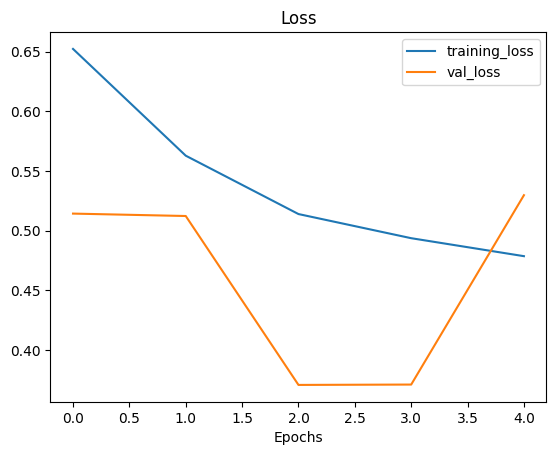

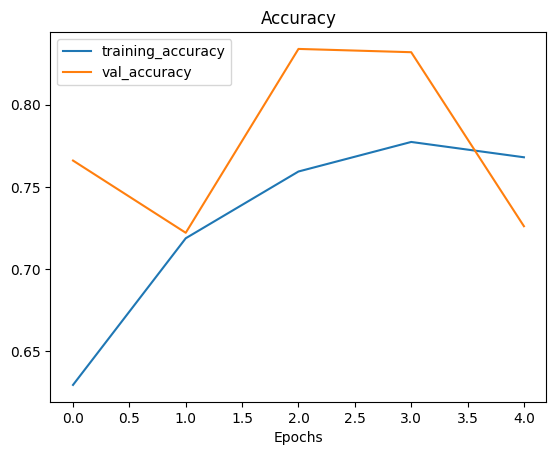

In [ ]:
# plot loss curves
plot_loss_curves(history_7)

When shuffling training data, the model gets exposed to all different kinds of data during training, thus enabling it to learn features across a wide array of images (pizza & steak instead of just pizza then steak)

### 7. repeat until satisfied

since we've already beeaten our baseline, there are a few things to try to continue to improve our model:

* increase num of model layers (eg add more Conv2d/moaxpool2d layers)
* increase the number of filters in each convolutional layer(eg from 10 to 32 or even 64)
* Train for longer
* Get more data (give the model more opportunities to learn)
* use transfer learning to leverage what another image model has learned and adjust it for our own use case.

Practice recreate model on the CNN explainer website and try it on the shuffled data.

In [ ]:
# create the model same as model_5 and 6.
model_cnn_explainer = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn_explainer.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_cnn_explainer.fit(train_data_augmented_shuffled, # fitting on augmented and shuffled data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 24s 469ms/step - loss: 0.6365 - accuracy: 0.6327 - val_loss: 0.4532 - val_accuracy: 0.8260
Epoch 2/5
47/47 [==============================] - 22s 477ms/step - loss: 0.5663 - accuracy: 0.7280 - val_loss: 0.4150 - val_accuracy: 0.8280
Epoch 3/5
47/47 [==============================] - 27s 571ms/step - loss: 0.5268 - accuracy: 0.7367 - val_loss: 0.3775 - val_accuracy: 0.8560
Epoch 4/5
47/47 [==============================] - 21s 437ms/step - loss: 0.5187 - accuracy: 0.7480 - val_loss: 0.3760 - val_accuracy: 0.8420
Epoch 5/5
47/47 [==============================] - 22s 475ms/step - loss: 0.5028 - accuracy: 0.7553 - val_loss: 0.3949 - val_accuracy: 0.8540


### Making a prediction with our trained model on our own custom data

In [ ]:
# classes were working with
print(class_names)

['pizza' 'steak']


--2023-12-11 00:46:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.1’

03-steak.jpeg.1     100%[===================>]   1.89M  --.-KB/s    in 0.05s   

2023-12-11 00:46:18 (40.7 MB/s) - ‘03-steak.jpeg.1’ saved [1978213/1978213]



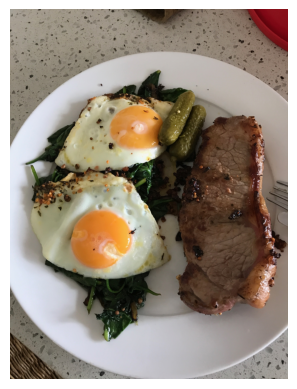

In [ ]:
# View our image example
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [ ]:
steak.shape

(4032, 3024, 3)

In [ ]:
steak

array([[[162, 158, 149],
        [163, 159, 150],
        [166, 162, 153],
        ...,
        [136,  17,  23],
        [140,  21,  27],
        [140,  21,  27]],

       [[164, 160, 151],
        [164, 160, 151],
        [164, 160, 151],
        ...,
        [133,  14,  20],
        [134,  15,  21],
        [137,  18,  24]],

       [[166, 162, 153],
        [165, 161, 152],
        [163, 159, 150],
        ...,
        [136,  17,  23],
        [134,  15,  21],
        [136,  17,  23]],

       ...,

       [[154, 132, 111],
        [142, 121, 100],
        [101,  80,  59],
        ...,
        [164, 155, 148],
        [152, 141, 135],
        [140, 129, 123]],

       [[141, 119,  96],
        [138, 118,  94],
        [106,  85,  64],
        ...,
        [158, 147, 141],
        [142, 131, 125],
        [138, 127, 121]],

       [[148, 126, 102],
        [148, 128, 103],
        [114,  93,  72],
        ...,
        [153, 142, 136],
        [138, 127, 121],
        [143, 132, 126]]

> When you train a neural network and want to make a prediction with it on you own custom data is preprocessed into the same format as the data your model was trained on.

In [ ]:
# create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads image from filename and turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels)
  """
  # read in the image
  img = tf.io.read_file(filename)
  # decode the read file into a tensor
  img = tf.image.decode_image(img)
  # resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # rescale the image(get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [ ]:
# needs to be in the shape [batch_size, width, height, color_channels]. Example dims
pred = model_7.predict(tf.expand_dims(steak, axis=0))

1/1 [==============================] - 0s 215ms/step


The model is outputting prediction probabilities. closer to 1 is steak and closer to 0 is pizza. Because binary classification

Looks like our custom image is being put thru the model, however it currently outputs a prediction probability. It would be nice if we can visualize the image as well as the models prediction.

In [ ]:
# we can index the predicted class by rounding the prediction probability and indexing on the class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
# round up is steak, round down its pizza
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [ ]:
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  """
  # import the target image and preprocess it
  img = load_and_prep_image(filename)
  # make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  # get the predicted class
  pred_class = class_names[int(tf.round(pred))]
  #plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 31ms/step


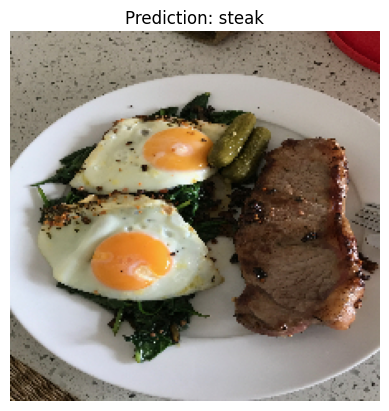

In [ ]:
# test our model on a custom image
pred_and_plot(model_7, "03-steak.jpeg")

The model works, lets try on another image

--2023-12-11 00:46:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  --.-KB/s    in 0.05s   

2023-12-11 00:46:22 (51.9 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]

1/1 [==============================] - 0s 28ms/step


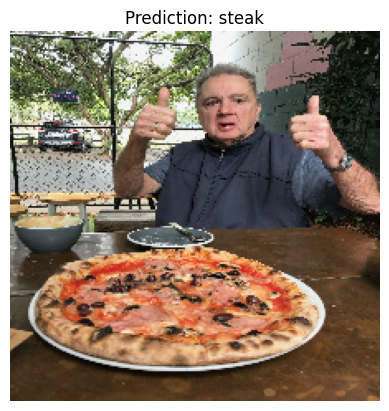

In [ ]:
# download another test custom image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
pred_and_plot(model_7, "03-pizza-dad.jpeg")

# Multi-Class Image Classification

We've done all of the following with a binary classification problem. Now ere increasing it to 10 classes of food.

1. become one with data
2. Preprocess the data (get it ready for a model)
3. create a model (start with baseline)
4. Fit the model (overfit to make sure it works)
5. Evaluate the model
6. Adjust different hyperparameters and improve the model (try to beat baseline/reduce overfitting)
7. Repeat until satisfied

## 1. Become one with data

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-12-11 00:46:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   256MB/s    in 1.9s    

2023-12-11 00:46:24 (256 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
import os

# walkthru 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [ ]:
# setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# lets get the classnames
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
random.choice(class_names)

'ice_cream'

['1548239.jpg']
Image shape: (512, 306, 3)


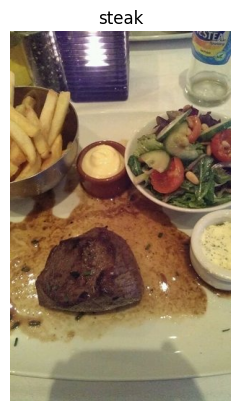

In [ ]:
# visualize, visualize
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Preprocess the data (prepare it for a model)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Create a model (start with baseline)

We've been talking alot about CNN explainer website. Lets use the model from that website (also on 10 classes).

In [ ]:
# create the model from CNN explainer website
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # 10 output neurons for 10 classes, and use softmax activation
])

# Compile the model
model_8.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_8 = model_8.fit(train_data, # now 10 different classes
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 47s 185ms/step - loss: 2.1264 - accuracy: 0.2145 - val_loss: 1.9761 - val_accuracy: 0.3036
Epoch 2/5
235/235 [==============================] - 36s 152ms/step - loss: 1.8838 - accuracy: 0.3445 - val_loss: 1.9497 - val_accuracy: 0.3040
Epoch 3/5
235/235 [==============================] - 28s 121ms/step - loss: 1.6307 - accuracy: 0.4499 - val_loss: 1.8696 - val_accuracy: 0.3524
Epoch 4/5
235/235 [==============================] - 28s 120ms/step - loss: 1.1621 - accuracy: 0.6139 - val_loss: 2.1196 - val_accuracy: 0.3272
Epoch 5/5
235/235 [==============================] - 31s 131ms/step - loss: 0.6116 - accuracy: 0.8025 - val_loss: 2.7815 - val_accuracy: 0.3056


## 5. Evaluate the model

In [ ]:
model_8.evaluate(test_data)

79/79 [==============================] - 7s 86ms/step - loss: 2.7815 - accuracy: 0.3056


[2.781477689743042, 0.30559998750686646]

Since there are 10 classes if the model was just guessing, the accuracy would be around 10%. So its doing a bit better than guessing.

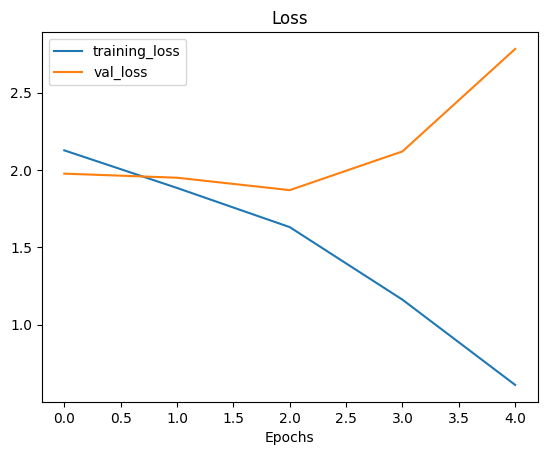

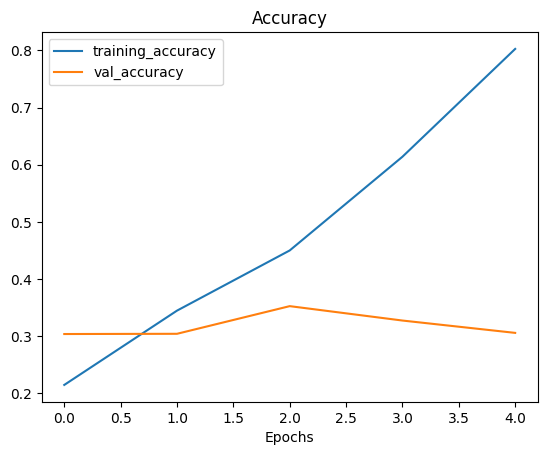

In [ ]:
# check out the models loss curves
plot_loss_curves(history_8)

Our model is potentially overfitting on the training data b/c validation loss is going up. Its not generalizing to unseen data.

The model is getting great results on the training data, but fails to generalize well on unseen data and performs poorly on test dataset.
Overfitting isnt generally a bad thing b/c at least your model is learning.

### Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

Due to performance on training data, its clear our model is learning something...

However its not generalizing well to unseen data(overfitting)

Fix it by:
* Get more data - having more data gives a model more opportunity to learn diverse patterns.
* Simplify the model - if our current model is overfitting the data, it may be too complicated of a model, one way to simplify a model is to: reduce num of layers or reduce hidden units
* Use data augmentation - manipulates the training data in such a way to add more diversity to it.
* Use transfer learning - transfer learning leverages the patterns another model learned on similar data to your own and allows you to use those patterns in your own dataset.

In [ ]:
# how bout we try and simplify the model first?
# aim for higher accuracy and we want the loss curves to be close to each other.
# create layer bt remove 2 conv layers
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax') # 10 output neurons for 10 classes, and use softmax activation
])

# Compile the model
model_9.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 31s 128ms/step - loss: 2.1914 - accuracy: 0.2035 - val_loss: 2.0214 - val_accuracy: 0.2632
Epoch 2/5
235/235 [==============================] - 27s 117ms/step - loss: 1.8732 - accuracy: 0.3540 - val_loss: 1.9194 - val_accuracy: 0.3268
Epoch 3/5
235/235 [==============================] - 26s 112ms/step - loss: 1.5670 - accuracy: 0.4739 - val_loss: 1.9170 - val_accuracy: 0.3212
Epoch 4/5
235/235 [==============================] - 28s 117ms/step - loss: 1.1146 - accuracy: 0.6472 - val_loss: 2.0646 - val_accuracy: 0.3140
Epoch 5/5
235/235 [==============================] - 27s 115ms/step - loss: 0.6411 - accuracy: 0.8116 - val_loss: 2.4000 - val_accuracy: 0.3100


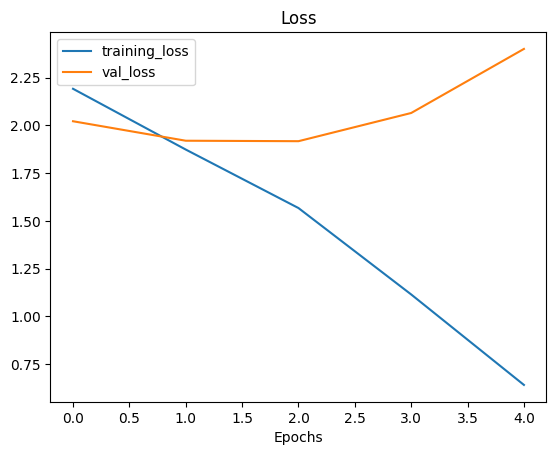

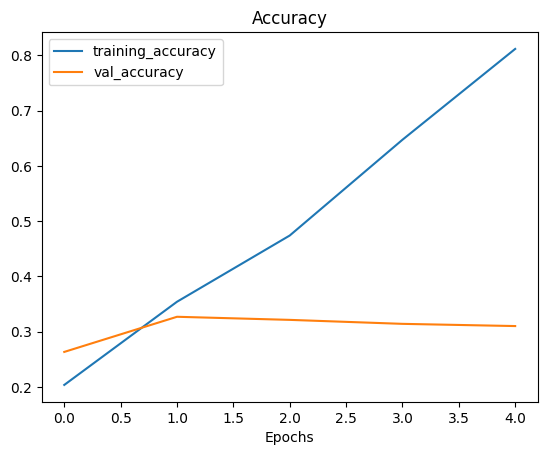

In [ ]:
plot_loss_curves(history_9)

In [ ]:
model_9.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 29160)             0         
                                                                 
 dense_16 (Dense)            (None, 10)              

In [ ]:
model_8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_29 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_31 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                               

Looks like our simplifying the model expirement didnt work...
* the accuracy went down and overfitting continued

### Try to reduce overfitting with data augmentation

Try and improve models results by using augmented training data...

Ideally we want to:
* reduce overfitting (get the train and validation loss curves closer)
* improve validation accuracy

In [ ]:
# create an augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255,
                                             rotation_range=0.2, # how much do u want to rotate an image
                                             zoom_range=0.2,
                                             width_shift_range=0.2, # move image around on the y axis
                                             height_shift_range=0.3, # move image around on the y axis
                                             horizontal_flip=True)
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.


In [ ]:
# lets create another model but this time we'll fit it on the augmented training data
model_10 = tf.keras.models.clone_model(model_8) # resets all of the internally learned patterns

# compile the model
model_10.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
model_10.summary()

NameError: ignored

In [ ]:
model_8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_29 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_31 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                               

In [ ]:
# fit the model
history_10 = model_10.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 109s 454ms/step - loss: 2.2705 - accuracy: 0.1348 - val_loss: 2.1433 - val_accuracy: 0.2216
Epoch 2/5
235/235 [==============================] - 107s 454ms/step - loss: 2.1559 - accuracy: 0.2119 - val_loss: 1.9693 - val_accuracy: 0.3108
Epoch 3/5
235/235 [==============================] - 107s 452ms/step - loss: 2.0588 - accuracy: 0.2668 - val_loss: 1.8949 - val_accuracy: 0.3452
Epoch 4/5
235/235 [==============================] - 107s 456ms/step - loss: 2.0291 - accuracy: 0.2783 - val_loss: 1.8525 - val_accuracy: 0.3672
Epoch 5/5
235/235 [==============================] - 111s 471ms/step - loss: 1.9963 - accuracy: 0.2953 - val_loss: 1.9337 - val_accuracy: 0.3512


takes a while cause the ImageDataGenerator augments data on the fly (as its being loaded into the model)

In [ ]:
model_8.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 2.7815 - accuracy: 0.3056


[2.781477689743042, 0.30559998750686646]

In [ ]:
model_10.evaluate(test_data)

79/79 [==============================] - 7s 91ms/step - loss: 1.9337 - accuracy: 0.3512


[1.9336938858032227, 0.35120001435279846]

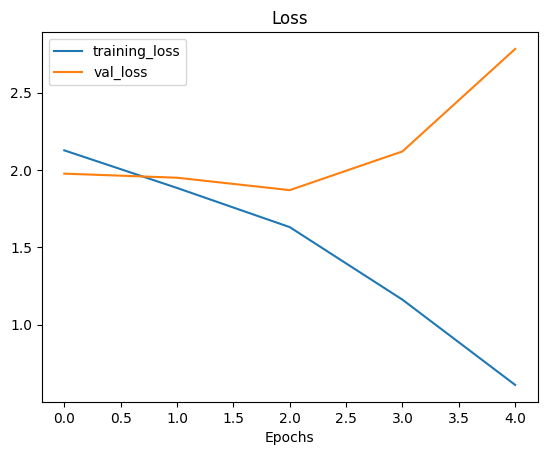

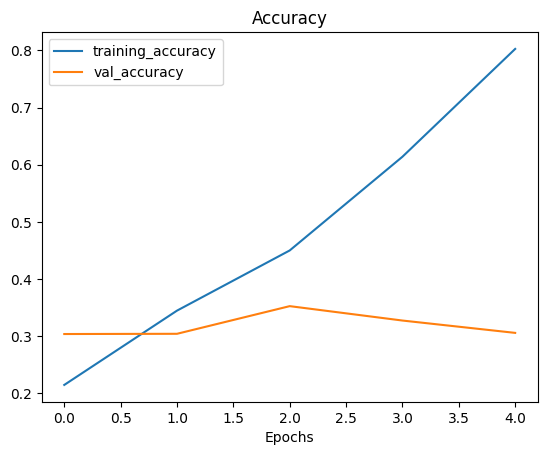

In [ ]:
plot_loss_curves(history_8)

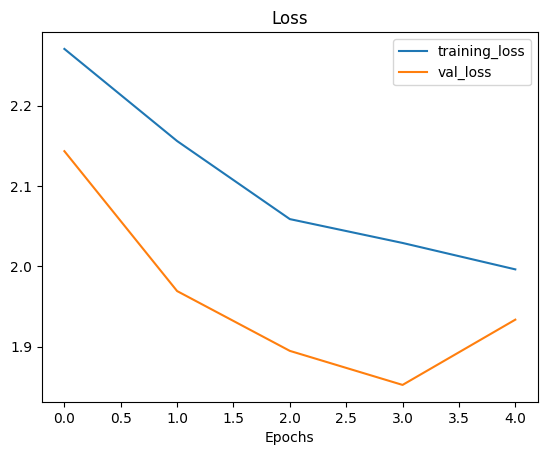

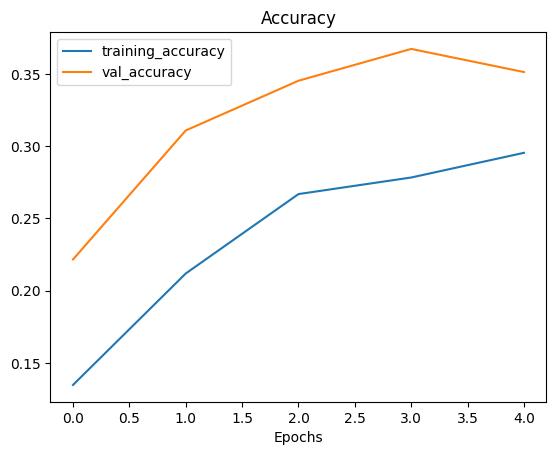

In [ ]:
plot_loss_curves(history_10)

Woah! that looks much better. The loss curves are much closere to each other than the baseline model and they look like they're heading in the right direction. So if we train for longer we might see further improvements.

## 7 Repeat until satisfied

We could keep going here...continually trying to bring our loss curves closer together and trying to improve the validation/test accuracy.

How?

By running lots of expirements:
* restructering our models architecture (increasing layers/hidden units)
* adjusting learning rates
* try different methods of data augmentation (adjust hyperparameters in our ImageGenerator instance)
* training for longer (5 to 10 epochs)

## Making a prediction with our trained model

use our trained model to make predictions on our own custom images!

In [ ]:
# remind ourselves of the classes our model is trained on
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# download some custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

--2023-12-11 01:03:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1725178 (1.6M) [image/jpeg]
Saving to: ‘03-sushi.jpeg.1’

03-sushi.jpeg.1     100%[===================>]   1.64M  --.-KB/s    in 0.04s   

2023-12-11 01:03:07 (37.8 MB/s) - ‘03-sushi.jpeg.1’ saved [1725178/1725178]

--2023-12-11 01:03:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respons

In [ ]:
# reconfig pred_and_plot function to work with multiple classes
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  """
  # import the target image and preprocess it
  img = load_and_prep_image(filename)
  # make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  #add in logic for multi-class
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])] # multi-class get the highest probability from a list
  else:
    pred_class = class_names[tf.round(pred[0])] # binary class

  # get the predicted class
  pred_class = class_names[int(tf.round(pred))]
  #plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
# make a prediction using model_10
# pred_and_plot(model=model_10,
#               filename="03-steak.jpeg",
#               class_names=class_names)

## Saving and loading our model

In [ ]:
# save a model
model_10.save("saved_trained_model_10")

NameError: ignored

In [ ]:
# load in a trained model and evaluate it
loaded_model_10 = tf.keras.models.load_model("saved_trained_model_10")
loaded_model_10.evaluate(test_data)

In [ ]:
# compare loaded model to ouse existing model
model_10.evaluate(test_data)